# [COM4513-6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)
- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)
- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**4 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**4 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)
- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparam combination  (**2 marks**). 
- After training the model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.
- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).

- **BONUS:** Extend you Feedforward network by adding more hidden layers (e.g. one more). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**+2 extra marks**)



### Data 

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. You are allowed to re-use your code from Assignment 1.

Please make sure to comment your code. You should also mention if you've used Windows to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1 of ~75-80% and ~85% without and with using pre-trained embeddings respectively. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module. If you implement the bonus question you can get up to 2 extra points but your final grade will be capped at 20.

The deadline for this assignment is **23:59 on Mon, 18 May 2020** and it needs to be submitted via Blackboard (MOLE). Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [250]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)
from datetime import datetime 
now = datetime.now()

## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [251]:
data_topic_train = pd.read_csv("data_topic/train.csv", names=["Label", "Text"])
data_topic_test = pd.read_csv("data_topic/test.csv", names=["Label", "Text"])
data_topic_dev = pd.read_csv("data_topic/dev.csv", names=["Label", "Text"])

In [252]:
# Split data into lists and np arrays

# TRAINING DATA
data_topic_train_data = list(data_topic_train.loc[:,"Text"])
Y_tr = np.array(data_topic_train.loc[:,"Label"])

# TEST SET
data_topic_test_data = list(data_topic_test.loc[:,"Text"])
Y_test = np.array(data_topic_test.loc[:,"Label"])


# VALIDATION SET
data_topic_dev_data = list(data_topic_dev.loc[:,"Text"])
Y_dev = np.array(data_topic_dev.loc[:,"Label"])

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [253]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']



# stop_words = ["monday","tuesday","wednesday","thursday","friday","saturday","sunday","0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [254]:

# token_pattern was changed to allow ' marks and one letter tokens


def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r"\b[A-Za-z\'][A-Za-z\']*\b", stop_words=[]):
    
    # To remove caps so to avoid e.g. This/this being seperate tokens   
    x_raw = x_raw.lower()
    
    # Tokenise document
    x_raw = re.findall(token_pattern,  x_raw)
    
    # filter out stopwords     
    tokens = [token for token in x_raw if token not in stop_words]
    
    # for each n-gram in ngram_range ---> construct a list of all n grams    
    sequences = []    
    for n in range(ngram_range[0], ngram_range[1] + 1) :   
        sequences.extend([tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)])
        
        
    return sequences



### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [255]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z\'][A-Za-z\']*\b', min_df=0, keep_topN=0, stop_words=[]):
    
    #  init empty values   
    df = dict()
    vocab = set()
    ngram_counts = []

    for x in X_raw : 
        # Get N-Grams for each document        
        v = extract_ngrams(x, ngram_range = ngram_range, token_pattern = token_pattern, stop_words = stop_words)
        
        # Add these ngrams to a list of words         
        ngram_counts.extend(v)
        
        # Remove duplications and add to the df dict accordingly   
        v = set(v)
        for item in list(v) :
            df[item] = df.get(item, 0) + 1
        
        # add the ngrams to the vocab        
        vocab |= v
    
    # Filter Document frequencies   
    df = {k: v for (k, v) in df.items() if v >= min_df}
    # Keep only the top N
    df = dict(list({k: v for (k, v) in sorted(df.items(), reverse = True, key=lambda x: x[1])}.items())[:keep_topN])
    
    # remove the filtered ngrams from the vocab
#     vocab = vocab.intersection(set(df.keys()))
    vocab = set(df.keys())
    # count the number of ngrams in the vocab 
    ngram_counts = [(x, y) for (x, y) in Counter(ngram_counts).items() if x in vocab]
    return vocab, df, ngram_counts


Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [256]:
# keeping a large N to try and mitigate the deep and the pre-trained model from underfitting
vocab, df, ngram_counts = get_vocab(data_topic_train_data, ngram_range=(1,1), keep_topN=10000, stop_words=stop_words)
print(len(vocab))

9184


Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [257]:
# vocabulary id -> word and word -> id
v_id = {i: v for i, v in enumerate(vocab)}
w_id = {v: i for i, v in v_id.items()}


### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [258]:
X_uni_train = [extract_ngrams(x, ngram_range=(1,1), stop_words=stop_words) for x in data_topic_train_data]
X_uni_dev = [extract_ngrams(x, ngram_range=(1,1), stop_words=stop_words) for x in data_topic_dev_data]
X_uni_test = [extract_ngrams(x, ngram_range=(1,1), stop_words=stop_words) for x in data_topic_test_data]


In [259]:
X_uni_train[0]

[('reuters',),
 ('venezuelans',),
 ('turned',),
 ('out',),
 ('early',),
 ('large',),
 ('numbers',),
 ('sunday',),
 ('vote',),
 ('historic',),
 ('referendum',),
 ('either',),
 ('remove',),
 ('left',),
 ('wing',),
 ('president',),
 ('hugo',),
 ('chavez',),
 ('office',),
 ('give',),
 ('him',),
 ('new',),
 ('mandate',),
 ('govern',),
 ('next',),
 ('two',),
 ('years',)]

In [260]:
# X_uni_tr[0]

Then convert them into lists of indices in the vocabulary:

In [261]:
X_tr = [[w_id[y] for y in x if y in vocab] for x in X_uni_train]
X_dev = [[w_id[y] for y in x if y in vocab] for x in X_uni_dev]
X_test = [[w_id[y] for y in x if y in vocab] for x in X_uni_test]

In [262]:
v_id[X_tr[0][0]]

('reuters',)

In [263]:
X_tr[0]

[2461,
 5013,
 5809,
 8824,
 7670,
 4557,
 6064,
 2309,
 3626,
 3522,
 2802,
 6835,
 6628,
 3859,
 1017,
 8678,
 6128,
 6277,
 2872,
 2797,
 2777,
 4377,
 8549,
 1268,
 1036,
 3135,
 2536]

Put the labels `Y` for train, dev and test sets into arrays: 

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W^T) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i^T $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers (for the Bonus). Empty if there are no hidden layers between the average embedding and the output layer 
- `num_clusses`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

See the examples below for expected outputs. Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [264]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    # Init W     
    W = {}
    
    # Init the embedding matrix     
    W[0] = np.random.uniform(low=-0.1, high=0.1, size=(vocab_size, embedding_dim)).astype('f')
    
    # init any hidden layes    
    for i, h in enumerate(hidden_dim) :
        W[i + 1] = np.random.uniform(low=-0.1, high=0.1, size=(W[i].shape[1], h)).astype('f')
    
    # Init weights to output layer     
    W[len(W)] = np.random.uniform(low=-0.1, high=0.1, size=(W[len(W) - 1].shape[1], num_classes)).astype('f')
    
    return W
    

In [265]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=2)
print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)

W_emb: (5, 10)
W_out: (10, 2)


In [266]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=2)

print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)

W_emb: (5, 10)
W_out: (10, 2)


In [267]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_out:', W[2].shape)
print(W)

W_emb: (3, 4)
W_h1: (4, 2)
W_out: (2, 2)
{0: array([[-0.08133466, -0.04062784,  0.08551685,  0.01380075],
       [-0.0085176 ,  0.0507052 ,  0.04837243, -0.09028419],
       [ 0.04173948,  0.06784867, -0.06681243,  0.05619959]],
      dtype=float32), 1: array([[-0.04269268, -0.03870605],
       [ 0.03305229, -0.07772157],
       [ 0.03297449,  0.07757136],
       [ 0.03926225, -0.01193442]], dtype=float32), 2: array([[-0.01235712,  0.05301922],
       [ 0.0131284 , -0.08301917]], dtype=float32)}


In [268]:
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_out:', W[2].shape)

W_emb: (3, 4)
W_h1: (4, 2)
W_out: (2, 2)


In [269]:
W[0]

array([[-0.08133466, -0.04062784,  0.08551685,  0.01380075],
       [-0.0085176 ,  0.0507052 ,  0.04837243, -0.09028419],
       [ 0.04173948,  0.06784867, -0.06681243,  0.05619959]],
      dtype=float32)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. It takes as input:

- `z`: array of real numbers 

and returns:

- `sig`: the softmax of `z`

In [270]:
def softmax(z):
    # Numerically stable softmax    
    z -= np.max(z)
    sig = np.exp(z) / np.sum(np.exp(z))
    
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:

In [271]:
def categorical_loss(y, y_preds):
    
    # Calculate the loss
    loss = -np.log(y_preds[y])

    return loss

In [272]:
# example for 5 classes

y = 2 #true label
y_preds = softmax(np.array([[-2.1,1.,0.9,-1.3,1.5]]))[0]

print('y_preds: ',y_preds)
print('loss:', categorical_loss(y, y_preds))

y_preds:  [0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]
loss: 1.40802648485675


In [273]:
# example for 5 classes

y = 2 #true label
y_preds = softmax(np.array([[-2.1,1.,0.9,-1.3,1.5]]))[0]

print('y_preds: ',y_preds)
print('loss:', categorical_loss(y, y_preds))

y_preds:  [0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]
loss: 1.40802648485675


Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu\_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [274]:
def relu(z):
    a = z.copy()
    # eq. to max(a, 0)   
    return a * (a > 0)

def relu_derivative(z):
    a = z.copy()
    return 1. * (a > 0)
 

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [275]:
def dropout_mask(size, dropout_rate):
    
    # Create a mask of booleans
    drop_out = np.random.uniform(low=0, high=1, size=size) > dropout_rate
    
    # Map True -> 1 and False -> 0  
    return drop_out * 1
    
    

In [276]:
print(dropout_mask(10, 0.2))

[1 1 1 1 1 1 1 0 1 1]


In [277]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1 0 0 0 1 1 1 0 1 1]
[1 1 0 1 1 1 1 1 1 1]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [278]:
def forward_pass(x, W, dropout_rate=0.2):
    
    # init list and dicts   
    out_vals = {}
    z_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    # for each layer    
    z_k = 0
    for i in range(0,len(W) - 1) :
        #  if its the embedding layer. Only forward pass the relevant words      
        if i == 0:
            # sum the weights and normalise by the number of indecies            
            for i in x:
                z_k += W[0][i].reshape(1,-1)
            z_k *= 1/len(x)
        else:
            z_k = h_prev.dot(W[i])
        
        # append pre-activated values         
        z_vecs.append(z_k)
        
        # activated values       
        h_prev = relu(z_k)
        
        # Apply dropout     
        dropout = dropout_mask(h_prev.shape, dropout_rate)
        dropout_vecs.append(dropout)
        h_prev *= dropout
        
        a_vecs.append(h_prev)

    #  Output layer   
    z_k = h_prev.dot(W[len(W) - 1])
    z_vecs.append(z_k)
    h_prev = softmax(z_k)
    pred = h_prev
    
    out_vals["z"] = z_vecs
    out_vals["a"] = a_vecs
    out_vals["dropout_vecs"] = dropout_vecs
    out_vals["y"] = pred
    
    
    return out_vals
    

In [279]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print()
f = forward_pass([2,1], W, dropout_rate=0.5)

Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 2)



In [280]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print()
print(forward_pass([2,1], W, dropout_rate=0.5))

Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 2)

{'z': [array([[ 0.02093661, -0.06007447,  0.0410862 ,  0.03663516]],
      dtype=float32), array([[-0.00066798, -0.0036264 ,  0.0001287 , -0.00178897, -0.00294294]],
      dtype=float32), array([[-2.853093e-06,  0.000000e+00]], dtype=float32)], 'a': [array([[ 0.02093661, -0.        ,  0.0410862 ,  0.        ]],
      dtype=float32), array([[-0.       , -0.       ,  0.0001287, -0.       , -0.       ]],
      dtype=float32)], 'dropout_vecs': [array([[1, 1, 1, 0]]), array([[1, 0, 1, 0, 1]])], 'y': array([[0.49999925, 0.5000007 ]], dtype=float32)}


The `backward_pass` function computes the gradients and update the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [281]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    l = len(W) - 1
    
    # loss as a one hot vector   
#     y_hat = categorical_loss(y, out_vals["y"][0])
    y_hot = np.zeros(shape = (W[l].shape[1]))
    y_hot[y] = 1
    
    # output layer 
    # dJ/dz = dJ/dy * dy/dz
    delta = (out_vals["y"] - y_hot).reshape(1,-1)
    
    # No need to update weights that were not used   
    dz_dw = out_vals["a"][l - 1].reshape(1,-1) * out_vals["dropout_vecs"][l - 1].reshape(1,-1)
    
    # dJ/dw = dJ/dz * dz/dw   
    dj_dw = dz_dw.T.dot(delta)
    
    # Apply gradient * learning to k layer     
    W[l] -= lr * dj_dw
    
    # for each hidden layer 
    for k in range(1, l)[::-1] :
        delta = (delta.dot(W[k + 1].T) * relu_derivative(out_vals["z"][k])).reshape(1,-1) * out_vals["dropout_vecs"][k].reshape(1,-1)
        dz_dw = out_vals["a"][k - 1].reshape(1,-1) * out_vals["dropout_vecs"][k - 1].reshape(1,-1)
        dj_dw = dz_dw.T.dot(delta)
        W[k] -= lr * dj_dw
    
    # input layers
    if not freeze_emb :
        delta = (delta.dot(W[1].T) * relu_derivative(out_vals["z"][0])).reshape(1,-1) * out_vals["dropout_vecs"][0].reshape(1,-1)
#         for i in x:
        W[0][x] -= (lr * delta)

    
    return W

In [282]:
arr = np.array([1,2,3,4,5]).reshape(-1,1)
hot = np.array([0,1,0]).reshape(-1,1)
print(arr.dot(hot.T))

[[0 1 0]
 [0 2 0]
 [0 3 0]
 [0 4 0]
 [0 5 0]]


Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [283]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    validation_loss_history = []
    training_loss_history = []
    # for each epoch     
    for e in range(epochs) :
        s = np.arange(0, len(Y_tr))
        np.random.shuffle(s)
        
        # Shuffle the order of the docs        
        X_tr = np.array(X_tr)[s]
        Y_tr = np.array(Y_tr)[s]
        
        # For each document in the training data descend in the gradient space         
        for i, x in enumerate(X_tr) :    
            out_vals = forward_pass(x, W, dropout_rate = dropout)
            W = backward_pass(x, Y_tr[i], W, out_vals, lr=lr, freeze_emb=freeze_emb)
        
        # Calculate validation loss        
        error = [forward_pass(x, W, dropout_rate = 0)['y'] for x in X_dev] 
        val = [categorical_loss(true, error[0]) for true,error in zip(Y_dev, error)]
        validation_loss_history.append(np.sum(val)/len(val))
        
        # Calculate training loss
        error = [forward_pass(x, W, dropout_rate = 0)['y'] for x in X_tr] 
        train = [categorical_loss(true, error[0]) for true,error in zip(Y_tr, error)]
        training_loss_history.append(np.sum(train)/len(train))
        if print_progress :
            print("epoch:", e, "| traininf loss:", training_loss_history[e], "| Validation loss:", validation_loss_history[e])
        
        # Stop when the difference between the current and previous validation loss is smaller than a threshold      
        if e > 0 and np.abs(validation_loss_history[e - 1] - validation_loss_history[e]) < tolerance :
            break
            
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [284]:
"""

A Naïve form of a grid-search to find good hyperparameters

"""
learning_rate = [0.01, 0.001]
dropout = [0.1, 0.2]
emb = [50, 300]

# Save best params in a hash
hist = {} 
i = 0
# for each hyperparam evaluate the model
for rate in learning_rate :
    for drop in dropout :
        for em in emb :
            W = network_weights(vocab_size=len(vocab), embedding_dim=em, hidden_dim=[], num_classes=3)
            W, loss_tr, dev_loss = SGD(X_tr, Y_tr - 1,
                                W,
                                X_dev=X_dev, 
                                Y_dev=Y_dev - 1,
                                lr=rate, 
                                dropout=drop,
                                freeze_emb=False,
                                tolerance=0.001,
                                epochs=100,
                                print_progress=False)

            # Evaluate         
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x in X_test]
            f1 = f1_score(Y_test - 1,preds_te,average='macro')

            hist[i] = {"learning_rate" : rate, "Drop" : drop, "emb" : em,"loss_tr" : loss_tr,"dev_loss" : dev_loss, "F1" : f1}
            print(i)
            i += 1

0
1
2
3
4
5
6
7


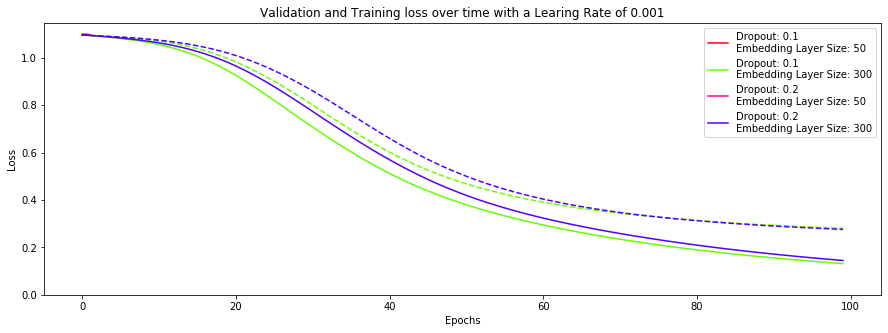

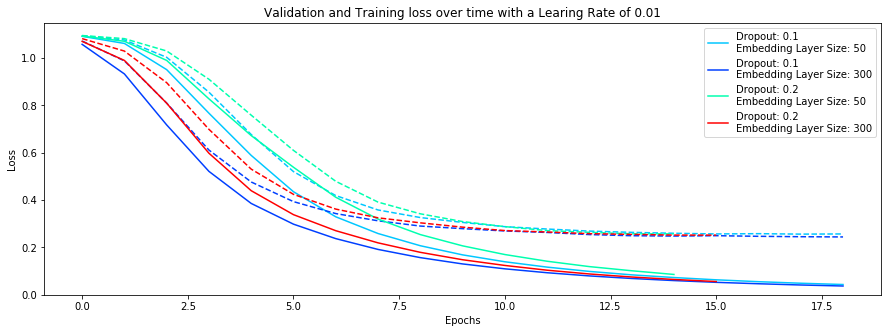

In [285]:
plt.figure(figsize=(15,5))

cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, 12)]
np.random.shuffle(colors)
for i in range(len(hist)) : 
    if hist[i]["learning_rate"] == 0.001 :
        plt.plot(hist[i]["loss_tr"],color = colors[i],label="Dropout: " + str(hist[i]["Drop"]) + "\nEmbedding Layer Size: " + str(hist[i]["emb"]) )
        plt.plot(hist[i]["dev_loss"],"--",color = colors[i])
plt.ylim(0,plt.ylim()[1])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Validation and Training loss over time with a Learing Rate of 0.001")
plt.legend()

plt.show()
plt.figure(figsize=(15,5))
for i in range(len(hist)) : 
    if hist[i]["learning_rate"] == 0.01 :
        plt.plot(hist[i]["loss_tr"],color = colors[i],label="Dropout: " + str(hist[i]["Drop"]) + "\nEmbedding Layer Size: " + str(hist[i]["emb"]))
        plt.plot(hist[i]["dev_loss"],"--",color = colors[i])
plt.title("Validation and Training loss over time with a Learing Rate of 0.01")
plt.ylim(0,plt.ylim()[1])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.show()
    
    


Both these graphs are used to compare the affect of the learing rate on learing. 

When the learing rate set to 0.01, the model terminates a lot faster than if it was set to 0.001. As 0.01 make SGD take larger jumps in the learing process. However, this can lead to unstabe training, which can be seen with greater overfitting compared to a learning rate of 0.001.

Secondly, some combination failed to even find a minimum. For example, with a learning rate of 0.001, dropout of 0.1, and an embedding size of 50 

[300.  50. 300.  50. 300. 300.  50.  50.]


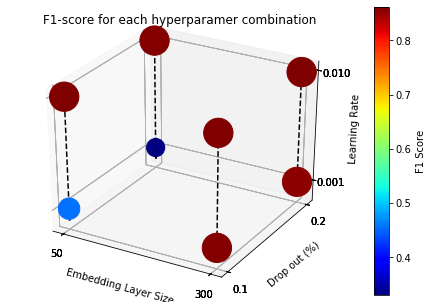

In [286]:
# unpack and sort the values
bars = [[x["emb"], x["Drop"], x["learning_rate"], x["F1"]] for x in list(hist.values())]
bars = sorted(bars, key=lambda x: x[3])[::-1]

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import random

fig = pyplot.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = np.array(bars)[:,0]
sequence_containing_y_vals = np.array(bars)[:,1]
sequence_containing_z_vals = np.array(bars)[:,2]

normalize = mcolors.Normalize(vmin=np.array(bars)[:,3].min(), vmax=np.array(bars)[:,3].max())
colormap = cm.jet

scatter = ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals, s = 1000*np.array(bars)[:,3], alpha=1, cmap = "jet", c = np.array(bars)[:,3])
print(np.array(bars)[:,0])

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap = colormap)
scalarmappaple.set_array(np.array(bars)[:,3])
plt.colorbar(scalarmappaple, label='F1 Score')

for i in bars :
    ax.plot([i[0],i[0]],[i[1],i[1]],[0,i[2]], "k--")

ax.set_title("F1-score for each hyperparamer combination")
ax.set_xlabel('Embedding Layer Size')
ax.set_xticks(np.array(bars)[:,0])
ax.set_ylabel('Drop out (%)')
ax.set_yticks(np.array(bars)[:,1])
ax.set_zlabel('Learning Rate')
ax.set_zticks(np.array(bars)[:,2])
pyplot.show()



This graph is a 3D representation of the hyperparmaters used in the Naïve grid search above. The size and colour of each dot is the F1 score of this point in the 3D space. 

The figure shows that most of the hyperparams used have little affect on the model. This can be seen by the majority of each dot being the same colour and size. 
The only hyperamter to have major affect on the model is the embedding size. This suggests that a small embedding size doesn't capture the complexity/relationship between words in the training data.

In [287]:
best = bars[0]
print(best)

[300, 0.2, 0.01, 0.8618603136056994]


In [288]:
W = network_weights(vocab_size=len(vocab), embedding_dim=best[0], hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)
print(len(X_tr))

W, loss_tr, dev_loss = SGD(X_tr, Y_tr - 1,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev - 1,
                            lr=best[2], 
                            dropout=best[1],
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=100)


Shape W0 (9184, 300)
Shape W1 (300, 3)
2400
epoch: 0 | traininf loss: 1.0696756998697916 | Validation loss: 1.0800217692057292
epoch: 1 | traininf loss: 0.986616719563802 | Validation loss: 1.0254597981770834
epoch: 2 | traininf loss: 0.8063135782877604 | Validation loss: 0.8909296671549479
epoch: 3 | traininf loss: 0.5957569376627604 | Validation loss: 0.6941747029622396
epoch: 4 | traininf loss: 0.43765945434570314 | Validation loss: 0.5256706746419271
epoch: 5 | traininf loss: 0.3369677225748698 | Validation loss: 0.4266197204589844
epoch: 6 | traininf loss: 0.2694958241780599 | Validation loss: 0.36072367350260415
epoch: 7 | traininf loss: 0.21886871337890626 | Validation loss: 0.3290845998128255
epoch: 8 | traininf loss: 0.1792676798502604 | Validation loss: 0.30169784545898437
epoch: 9 | traininf loss: 0.14833686828613282 | Validation loss: 0.2859285990397135
epoch: 10 | traininf loss: 0.12346720377604167 | Validation loss: 0.27537770589192706
epoch: 11 | traininf loss: 0.1043023

Plot the learning process:

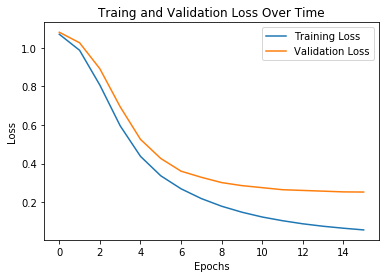

In [289]:
plt.plot(loss_tr, label="Training Loss")
plt.plot(dev_loss,label="Validation Loss")
plt.legend()
plt.title("Traing and Validation Loss Over Time")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

This graph shows that the model is overfitting.

In [290]:
def conf(pred, labels) :
    N = len(np.unique(labels))
    result = np.zeros((N, N))
    for i in range(len(Y_test)):
        result[labels[i]][pred[i]] += 1
    return result

Compute accuracy, precision, recall and F1-Score:

In [291]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x in X_test]
print(conf(preds_te,Y_test - 1))
print('Accuracy:', accuracy_score(Y_test - 1,preds_te))
print('Precision:', precision_score(Y_test - 1,preds_te,average='macro'))
print('Recall:', recall_score(Y_test - 1,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test - 1,preds_te,average='macro'))

[[252.  25.  23.]
 [ 17. 279.   4.]
 [ 45.  12. 243.]]
Accuracy: 0.86
Precision: 0.8618197210352334
Recall: 0.86
F1-Score: 0.8597742134429945


### Discuss how did you choose model hyperparameters ? 

Due to timing constraints I only chose a small number of values for each hyperparameter. The hyperparameters I chose to test were the learning rate, dropout, and embedding size. I then used a grid search to search all the possible combinations of values to find the set that produced the best f1 score. 

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary.

In [292]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                # Change the keytype to tuple, otherwise a key error occurs      
                word = tuple([line.split()[0]])
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] += emb
    return w_emb

In [293]:
w_glove = get_glove_embeddings("glove.840B.300d.zip", "glove.840B.300d.txt", w_id)

In [294]:
print(w_glove.shape)

(9184, 300)


First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [295]:
learning_rate = [0.01, 0.001]
dropout = [0.1, 0.2]

# Save best params in a hash
hist = {} 
i = 0
# for each hyperparam evaluate the model
for rate in learning_rate :
    for drop in dropout :
        W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=[], num_classes=3)
        W[0] = w_glove
        W, loss_tr, dev_loss = SGD(X_tr, Y_tr - 1,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev - 1,
                            lr=rate, 
                            dropout=drop,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=100,
                            print_progress=False)

        # Evaluate         
        preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x in X_test]
        f1 = f1_score(Y_test - 1,preds_te,average='macro')

        hist[i] = {"learning_rate" : rate, "Drop" : drop,"loss_tr" : loss_tr,"dev_loss" : dev_loss, "F1" : f1}
        print(i)
        i += 1

0
1
2
3


In [296]:
bars = [[x["Drop"], x["learning_rate"], x["F1"]] for x in list(hist.values())]
bars = sorted(bars, key=lambda x: x[2])[::-1]
best = bars[0]

In [297]:
W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=[], num_classes=3)

W[0] = w_glove
W, loss_tr, dev_loss = SGD(X_tr, Y_tr - 1,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev - 1,
                            lr=best[1], 
                            dropout=best[0],
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=100)

epoch: 0 | traininf loss: 0.6192117322170784 | Validation loss: 0.6269843241227214
epoch: 1 | traininf loss: 0.4901659236754561 | Validation loss: 0.4757208955287531
epoch: 2 | traininf loss: 0.4335408417383433 | Validation loss: 0.38618641520732333
epoch: 3 | traininf loss: 0.4065101249576015 | Validation loss: 0.3644450222054185
epoch: 4 | traininf loss: 0.3790827273971678 | Validation loss: 0.31275493253016234
epoch: 5 | traininf loss: 0.368265514922869 | Validation loss: 0.29491831334460505
epoch: 6 | traininf loss: 0.3613127867551521 | Validation loss: 0.2942088704662931


In [298]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_test,Y_test)]
print(conf(preds_te,Y_test - 1))
print('Accuracy:', accuracy_score(Y_test - 1,preds_te))
print('Precision:', precision_score(Y_test - 1,preds_te,average='macro'))
print('Recall:', recall_score(Y_test - 1,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test - 1,preds_te,average='macro'))

[[252.  19.  29.]
 [ 15. 270.  15.]
 [ 24.   3. 273.]]
Accuracy: 0.8833333333333333
Precision: 0.8839452179534071
Recall: 0.8833333333333333
F1-Score: 0.8832937022617727


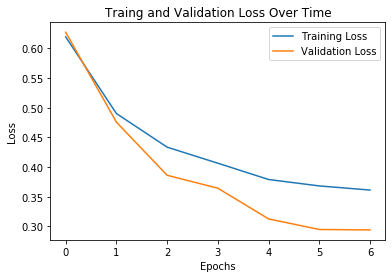

In [299]:
plt.plot(loss_tr, label="Training Loss")
plt.plot(dev_loss,label="Validation Loss")
plt.legend()
plt.title("Traing and Validation Loss Over Time")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

This figure shows that the model is underfitting as the validation loss is lower than the training loss.

### Discuss how did you choose model hyperparameters ? 

For this model I only tested the learning rate and the dropout rate. This is due to the fact that the embedding size is fixed to 300. Furthermorem, due to time constraints, I only tested two values for each hyperparameter.

I then used a grid search to search all the possible combinations of values to find the set that produced the best f1 score.

# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

In [300]:
learning_rate = [0.001]
dropout = [0.1]
dims = [[150],[5]]

# Save best params in a hash
hist = {} 
i = 0
# for each hyperparam evaluate the model
for rate in learning_rate :
    for drop in dropout :
        for d in dims:
            W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=d, num_classes=3)
            W[0] = w_glove
            W, loss_tr, dev_loss = SGD(X_tr, Y_tr - 1,
                                W,
                                X_dev=X_dev, 
                                Y_dev=Y_dev - 1,
                                lr=rate, 
                                dropout=drop,
                                freeze_emb=True,
                                tolerance=0.0001,
                                epochs=100,
                                print_progress=False)

            # Evaluate         
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x in X_test]
            f1 = f1_score(Y_test - 1,preds_te,average='macro')

            hist[i] = {"Hidden" : d, "learning_rate" : rate, "Drop" : drop,"loss_tr" : loss_tr,"dev_loss" : dev_loss, "F1" : f1}
            print(i)
            i += 1

0
1


In [301]:
bars = [[x["Drop"], x["learning_rate"], x["F1"],x["Hidden"]] for x in list(hist.values())]
bars = sorted(bars, key=lambda x: x[2])[::-1]
best = bars[0]
print(best)
print(np.array(bars)[:,2])

[0.1, 0.001, 0.9007149497252631, [5]]
[0.9007149497252631 0.8986397453432379]


In [302]:
W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=best[3], num_classes=3)
print(len(vocab))
W[0] = w_glove
W, loss_tr, dev_loss = SGD(X_tr, Y_tr - 1,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev - 1,
                            lr=best[1], 
                            dropout=best[0],
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=100)

9184
epoch: 0 | traininf loss: 1.0989870650570455 | Validation loss: 1.099024261888927
epoch: 1 | traininf loss: 1.098449419481501 | Validation loss: 1.0984795861344807
epoch: 2 | traininf loss: 1.0979237521991425 | Validation loss: 1.0979284180956645
epoch: 3 | traininf loss: 1.097093288085501 | Validation loss: 1.097071943234441
epoch: 4 | traininf loss: 1.0956705118257246 | Validation loss: 1.095654678927923
epoch: 5 | traininf loss: 1.0931814549706433 | Validation loss: 1.0931984267021293
epoch: 6 | traininf loss: 1.088970597647019 | Validation loss: 1.0891623487495197
epoch: 7 | traininf loss: 1.0823311919236038 | Validation loss: 1.0824817473093618
epoch: 8 | traininf loss: 1.0712401850584965 | Validation loss: 1.071608134845395
epoch: 9 | traininf loss: 1.0544599801732921 | Validation loss: 1.0548422782376472
epoch: 10 | traininf loss: 1.0315515717537576 | Validation loss: 1.031899692078932
epoch: 11 | traininf loss: 1.0023891752076115 | Validation loss: 1.0018804486653372
epoch

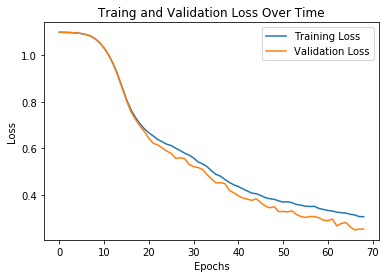

In [303]:
plt.plot(loss_tr, label="Training Loss")
plt.plot(dev_loss,label="Validation Loss")
plt.legend()
plt.title("Traing and Validation Loss Over Time")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

This figure shows that the model is underfitting as the validation loss is lower than the training loss.

In [304]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate = 0.0)['y']) for x,y in zip(X_test,Y_test)]
print(conf(preds_te,Y_test - 1))
print('Accuracy:', accuracy_score(Y_test - 1,preds_te))
print('Precision:', precision_score(Y_test - 1,preds_te,average='macro'))
print('Recall:', recall_score(Y_test - 1,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test - 1,preds_te,average='macro'))

[[256.  20.  24.]
 [ 21. 278.   1.]
 [ 34.   1. 265.]]
Accuracy: 0.8877777777777778
Precision: 0.8889033717126101
Recall: 0.8877777777777777
F1-Score: 0.8881631047754778


### Discuss how did you choose model hyperparameters ? 

For this model I only tested the size of the hidden layer. This is due to due to time constraints and I only tested two values for the hyperparameter and they were chosen at random.

I then used a grid search to search all the possible combinations of values to find the set that produced the best f1 score. 

In [305]:
current_time = datetime.now() - now
print("Total Time =", current_time)

Total Time = 0:13:13.832448


## Full Results

Add your final results here: to 4.s.f.

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |  0.8618 |  0.86|  0.8598 | 0.86  |
| Average Embedding (Pre-trained)  | 0.8839 | 0.8833  | 0.8833  | 0.8833 |
| Average Embedding (Pre-trained) + X hidden layers (BONUS)   |  0.8889 | 0.8878| 0.8882  |  0.8877 |


## Conclusion

As you can see the averge embedding performed the worst with an f-1 score of 0.8598. The use of a pre-trained embedding layer impoved the results of the model to 0.8833. However, this led to under fitting in the model. Lastly, the use of hidden layers had only minor effects on the model's performance but gave the best f-1 socre of 0.8882